In [1]:
from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
from scipy.stats import norm

#plt.style.use('dark_background')
rc('font', size=15)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)

fig_size = (12, 5)

In [3]:
from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O, abel_inversion, full_analysis
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
#from SimulateGroupDelayDispersive import create_density, create_ne_drop
from skreflectometry.data_generation import density_profile, density_add_bump
from skreflectometry.reflectometry_sim import phase_delay, group_delay, beat_signal, beat_maximums
from skreflectometry.graphs import plot_signal_profile, plot_profiles_reconstruction

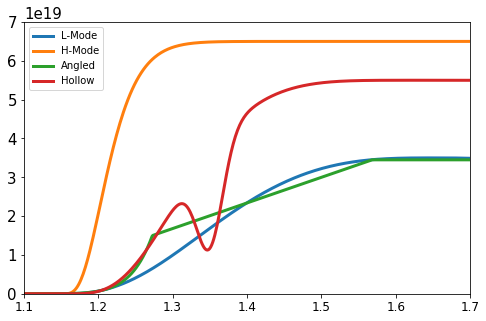

In [4]:
### Profiles ###

# L-Mode

radius_L, dens_L = density_profile(dens_central=3.5e19, m=3, n=3, n_points=1000)

# H-Mode

radius_H, dens_H = density_profile(dens_central=6.5e19, r_lfs=2.2, m=15, n=5, n_points=1000)
#radius_H = (radius_H[-1] + radius_H[0]) - radius_H

# Angled

radius_A = np.linspace(0,4.5, num=1000)
dens_A = np.zeros_like(radius_A)

poly_zone = (radius_A > 0.5)# & (radius_A <= 1)
dens_A[poly_zone] = np.power(radius_A[poly_zone] - 0.2, 8.) * 1.5e19

linear_zone = (radius_A > 1.2)# & (radius_A <= 2)
dens_A[linear_zone] = (radius_A[linear_zone] - 0.2) * 1.5e19

flat_zone = np.where(radius_A > 2.5)
dens_A[flat_zone] = dens_A[flat_zone[0][0] - 1]

radius_A = radius_A/4.4 + 1

# Hollow (non-Differiantiable)

def normal_pdf(x, x0=0, sigma=1, a=1):
    return a * np.exp(-np.power(x-x0, 2.) / np.power(sigma, 2.))

radius_D, dens_D = density_profile(dens_central=5.5e19, m=5, n=5, n_points=1000)
dens_D -= normal_pdf(radius_D, 1.35, 0.025, 2.5e19)
dens_D[dens_D < 0] = 0

# All profiles

plt.figure(figsize=(8, 5))

plt.plot(radius_L, dens_L, lw=3, label='L-Mode')
plt.plot(radius_H, dens_H, lw=3, label='H-Mode')
plt.plot(radius_A, dens_A, lw=3, label='Angled')
plt.plot(radius_D, dens_D, lw=3, label='Hollow')

plt.xlim(1.1, 1.7)
plt.ylim(0, 7e19)

plt.legend()

plt.show()

In [5]:
### Calcs ###

f_samp_L, f_probe_L, beat_sig_L, sweep_time_L, radius_c_L, dens_c_L, radius_s_L, dens_s_L = full_analysis(radius_L, dens_L, f_probe_limits=[1, 60e9])
f_samp_H, f_probe_H, beat_sig_H, sweep_time_H, radius_c_H, dens_c_H, radius_s_H, dens_s_H = full_analysis(radius_H, dens_H, f_probe_limits=[1, 80e9])
f_samp_A, f_probe_A, beat_sig_A, sweep_time_A, radius_c_A, dens_c_A, radius_s_A, dens_s_A = full_analysis(radius_A, dens_A, f_probe_limits=[1, 60e9])
f_samp_D, f_probe_D, beat_sig_D, sweep_time_D, radius_c_D, dens_c_D, radius_s_D, dens_s_D = full_analysis(radius_D, dens_D, f_probe_limits=[1, 70e9])

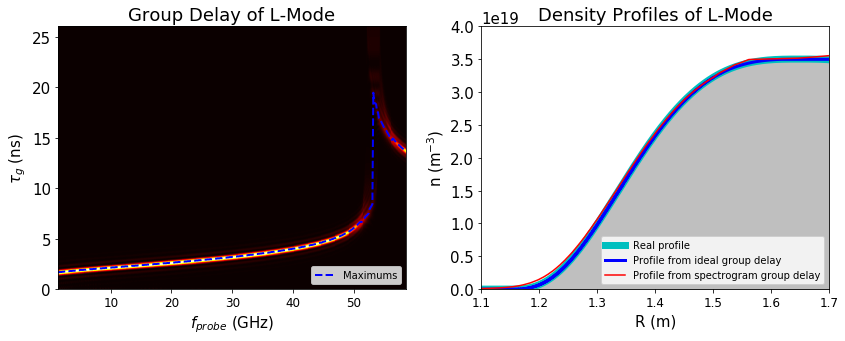

In [6]:
### L-Mode ###

plot_signal_profile(radius_L, dens_L, f_samp_L, f_probe_L, beat_sig_L, sweep_time_L, radius_c_L, dens_c_L, radius_s_L, dens_s_L,
                     figsize=fig_size, filename='L_Mode', title='L-Mode', dens_xlims=(1.1, 1.7), dens_ylims=(0, 4e19))

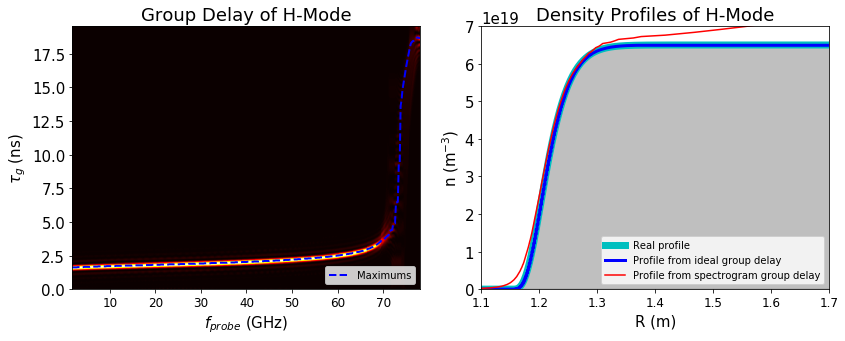

In [7]:
### H-Mode ###

plot_signal_profile(radius_H, dens_H, f_samp_H, f_probe_H, beat_sig_H, sweep_time_H, radius_c_H, dens_c_H, radius_s_H, dens_s_H,
                     figsize=fig_size, filename='H_Mode', title='H-Mode', dens_xlims=(1.1, 1.7), dens_ylims=(0, 7e19))

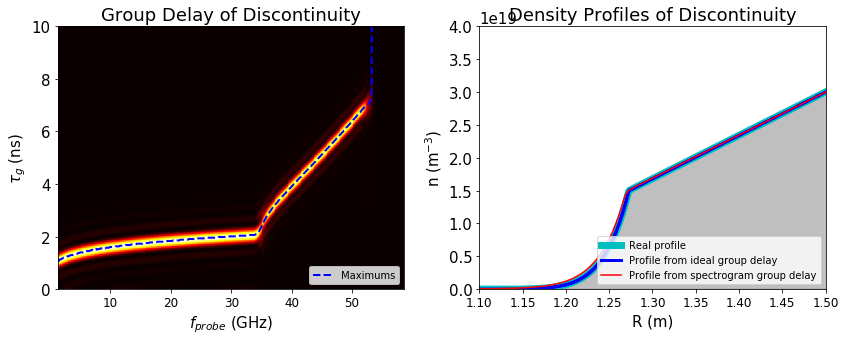

In [8]:
### Angled ###

plot_signal_profile(radius_A, dens_A, f_samp_A, f_probe_A, beat_sig_A, sweep_time_A, radius_c_A, dens_c_A, radius_s_A, dens_s_A,
                     figsize=fig_size, filename='Angled', title='Discontinuity', beat_ylims=(0, 10), dens_xlims=(1.1, 1.5), dens_ylims=(0, 4e19))

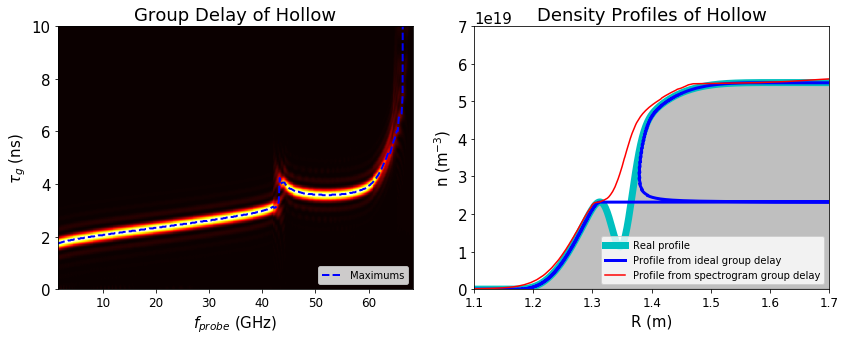

In [9]:
### Hollow ###

plot_signal_profile(radius_D, dens_D, f_samp_D, f_probe_D, beat_sig_D, sweep_time_D, radius_c_D, dens_c_D,
                    radius_s_D, dens_s_D,
                    figsize=fig_size, filename='Hollow', title='Hollow', beat_ylims=(0, 10), dens_xlims=(1.1, 1.7), dens_ylims=(0, 7e19))

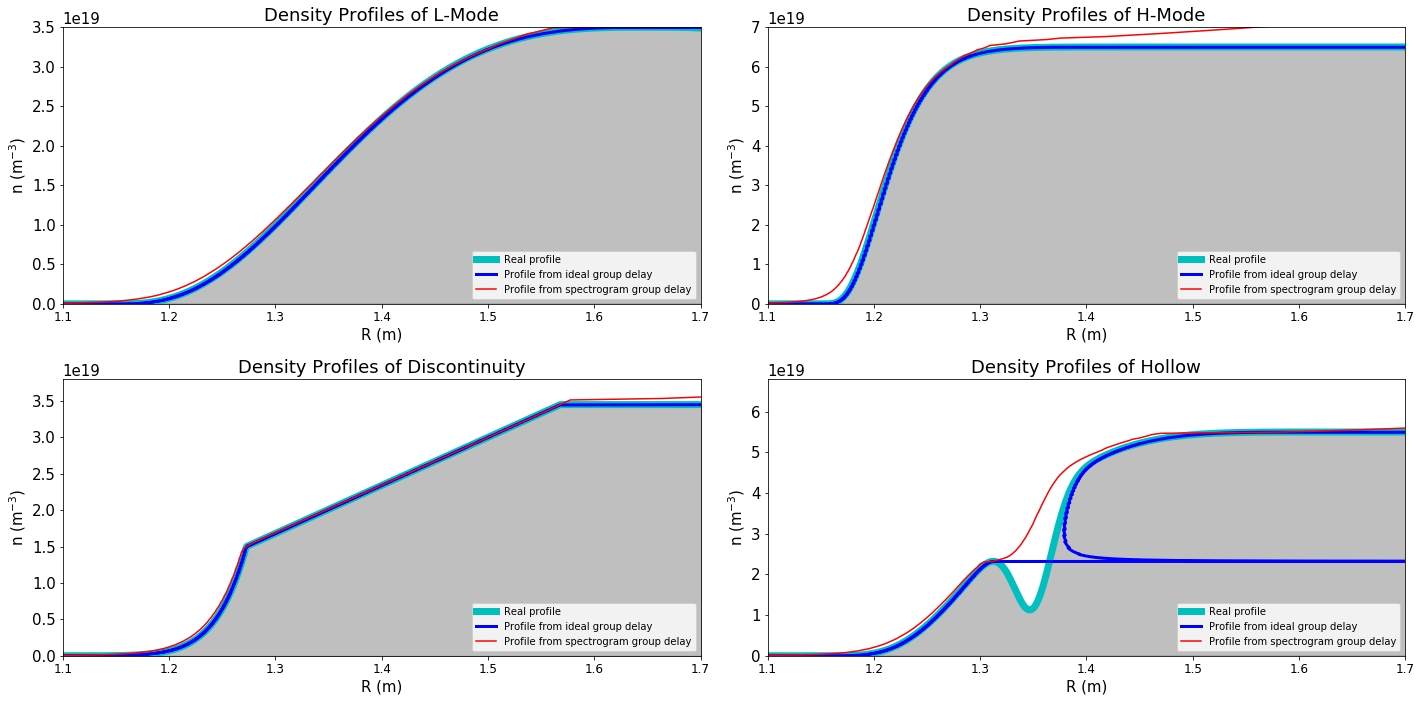

In [10]:
### Just Profiles

data_all = [
    (
        (radius_L, dens_L, radius_c_L, dens_c_L, radius_s_L, dens_s_L),
        {'xlims': (1.1, 1.7), 'ylims': (0, 3.5e19), 'title': 'L-Mode'}
    ),
    (
        (radius_H, dens_H, radius_c_H, dens_c_H, radius_s_H, dens_s_H),
        {'xlims': (1.1, 1.7), 'ylims': (0, 7e19), 'title': 'H-Mode'}
    ),
    (
        (radius_A, dens_A, radius_c_A, dens_c_A, radius_s_A, dens_s_A),
        {'xlims': (1.1, 1.7), 'ylims': (0, 3.8e19), 'title': 'Discontinuity'}
    ),
    (
        (radius_D, dens_D, radius_c_D, dens_c_D, radius_s_D, dens_s_D),
        {'xlims': (1.1, 1.7), 'ylims': (0, 6.8e19), 'title': 'Hollow'}
    ),
]

plt.figure(figsize=(20, 10))

for i, (args, kwargs) in enumerate(data_all, start=1):
    plt.subplot(2, 2, i)
    
    plot_profiles_reconstruction(*args, **kwargs)
    
plt.tight_layout()
plt.savefig('images/all_profiles.png', dpi=200)
plt.show()